In [61]:
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tsa.preprocessing import get_sample_info
from tsa.utils import inference_timeseries, list2floats, all_numeric

# default image size
plt.rcParams['figure.figsize'] = [8, 6]

# Input files

In [2]:
tpm_file = "data/XT9.1-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "data/owensA1_mpf_samples.tsv"

new_gpr = False
gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
gpr_scores_file = "data/owensA1_mpf_score.tsv"
showcase_gene = "ENSXETG00000000002"

In [3]:
# retrieve all alignments made to this template
alignment_dir = "alignments"
template_prefix = os.path.basename(template_samples_file).replace("_samples.tsv", "")
pattern = template_prefix + "*_alignment.tsv"
alignment_files = glob.glob(os.path.join(alignment_dir, pattern))
alignment_files.sort()

alignment_files

['alignments/owensA1_mpf_to_owensA1_mpf_alignment.tsv',
 'alignments/owensA1_mpf_to_owensA2_mpf_alignment.tsv',
 'alignments/owensA1_mpf_to_owensB1_mpf_alignment.tsv',
 'alignments/owensA1_mpf_to_tanA_mpf_alignment.tsv',
 'alignments/owensA1_mpf_to_tanB_mpf_alignment.tsv']

In [4]:
template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
extended_timepoints = list2floats(template_tpms_inf.columns)

template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

In [5]:
# def read_alignments(template_samples_file, query_samples_file, alignment_dir):
#     t_fname = os.path.basename(template_samples_file).replace("_samples.tsv", "")
#     q_fname = os.path.basename(query_samples_file).replace("_samples.tsv", "")
#     alignment_file = os.path.join(alignment_dir, f"{t_fname}_to_{q_fname}_alignment.tsv")

#     alignment = pd.read_csv(alignment_file, sep="\t", index_col=0)
#     return alignment, q_fname, t_fname

# alignment, query_label, template_label = read_alignments(template_samples_file, query_samples_files[0], alignment_dir)
# print(query_label)
# alignment.head(3)

In [6]:
def read_alignments(alignment_file):
    fname = os.path.basename(alignment_file)
    t_fname = fname.split("_to_")[0]
    q_fname = fname.split("_to_")[1].replace("_alignment.tsv", "")
    alignment = pd.read_csv(alignment_file, sep="\t", index_col=0)
    return alignment, q_fname, t_fname

# alignment, q_fname, t_fname = read_alignments(alignment_files[0])
# print(q_fname, t_fname)
# alignment.head(3)

## alignment plot for all-numeric-time annotated series

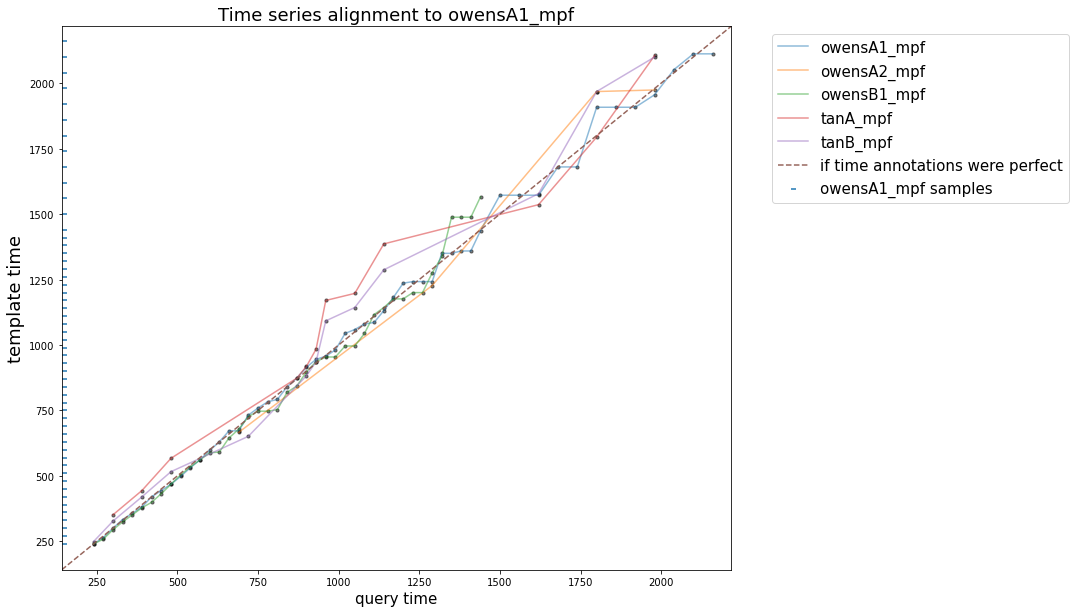

In [11]:
def plot_multi_alignment(template_timepoints, alignment_files):
    # limit the plot to the range of the query series (plus padding)
    start = template_timepoints[0]
    end = 0

    # plot each time series
    for alignment_file in alignment_files:
        alignment, query_label, template_label = read_alignments(alignment_file)
        x = alignment.index  # annotated_time
        y = alignment.inferred_time
        plt.plot(x, y, alpha=0.5, label=query_label)
        plt.scatter(x, y, alpha=0.5, s=10, color="black")

        end = max(end, y.iloc[-1]*1.05)
    start = start - (end - start)*0.05

    # add template samples at their annotated time on the y-axis
    ts_y = template_timepoints
    ts_x = start+end*0.003  # more the points into the plot a little (for visual clarity)
    plt.scatter([ts_x for i in ts_y], ts_y, alpha=1, s=25, label=f"{template_label} samples", marker='_')

    # add diagonal
    plt.plot([start, end], [start, end], label="if time annotations were perfect", alpha=0.9, ls='--')

    plt.xlim(start, end)
    plt.ylim(start, end)

    plt.title(f"Time series alignment to {template_label}", fontsize=18)
    plt.ylabel("template time", fontsize=18)
    plt.xlabel("query time", fontsize=15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
    plt.show()

# plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.figsize'] = [12, 10]

template_time = list2floats(template_time2samples)
plot_multi_alignment(template_time, alignment_files)

### alignment timeline for either numeric or non-numeric template time

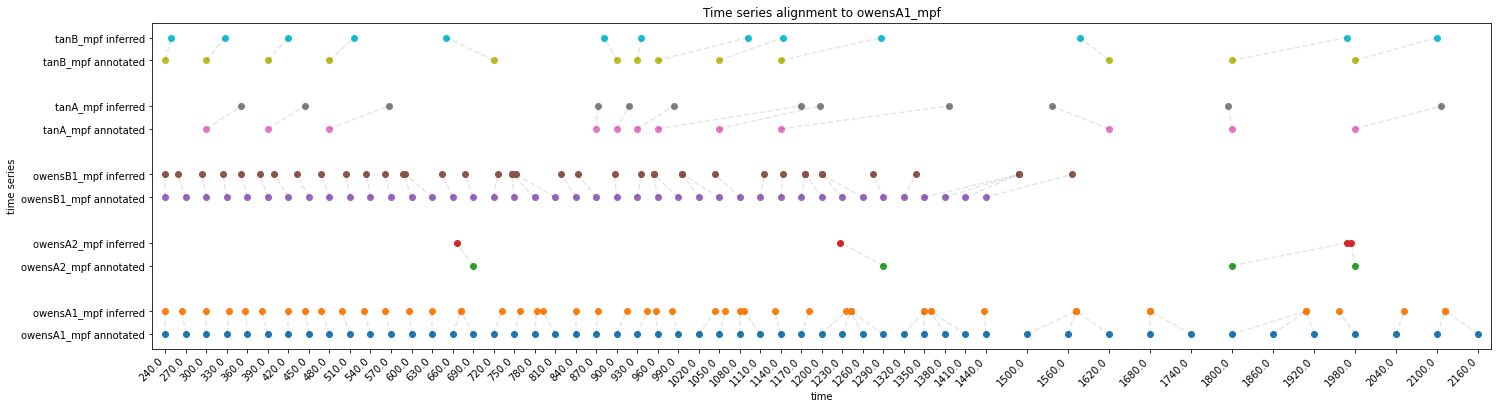

In [63]:
def plot_timeline(template: pd.DataFrame, alignment_files: dict):
    dt = template.index.dtype
    xlabels = list(template.xlabels.dropna())
    xticks = list(template.xticks.dropna())
    
    ylabels = []
    yticks = []
    n = 0
    for alignment_file in alignment_files:
        query, query_label, template_label = read_alignments(alignment_file)
        query.index.astype(dt)
        
        # plot annotated time
        x1 = list(template.loc[query.index]["x"])        
        y = list(np.zeros_like(x1) + n)
        label = f"{query_label} annotated"
        plt.scatter(x=x1, y=y, label=label)
        ylabels.append(label)
        yticks.append(n)
        n += 1
        
        # plot inferred time
        x2 = list(template.loc[query.inferred_time]["x"])
        y = list(np.zeros_like(x2) + n)
        label = f"{query_label} inferred"
        plt.scatter(x=x2, y=y, label=label)
        ylabels.append(label)
        yticks.append(n)
        n += 1
        
        # plot connections between annotated and inferred times
        matches = zip(x1, x2)
        for i, j in matches:
            plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')
        
        # add spacing between series
        n += 1
    
    plt.title(f"Time series alignment to {template_label}")
    
    plt.xlabel("time")
    plt.xticks(xticks, xlabels, rotation=45, ha="right")
    x_padding = (max(xticks)-min(xticks))*0.01
    plt.xlim(min(xticks) - x_padding, max(xticks) + x_padding)
    
    plt.ylabel("time series")
    plt.yticks(yticks, ylabels)
    
    plt.show()
    return


# wide image
plt.rcParams['figure.figsize'] = [24, 6]

# create a dataframe with extended_timepoints as index, 
# and a numeric columns "x" to serve as axis.
# columns xticks and xlabels can be used to populate the plot axis.
template_time = list2floats(template_time2samples)
x = []
xticks = []
xlabels = []
for n, t in enumerate(extended_timepoints):
    x.append(t if is_num else n)  # use numeric values of template time, if possible
    if t in template_time:
        xticks.append(x[n])
        xlabels.append(t)
    else:
        xticks.append(np.NaN)
        xlabels.append(np.NaN)      
template = pd.DataFrame({
    "template_time": extended_timepoints,
    "x": x,
    "xticks": xticks,
    "xlabels": xlabels,
}).set_index("template_time")

plot_timeline(template, alignment_files)


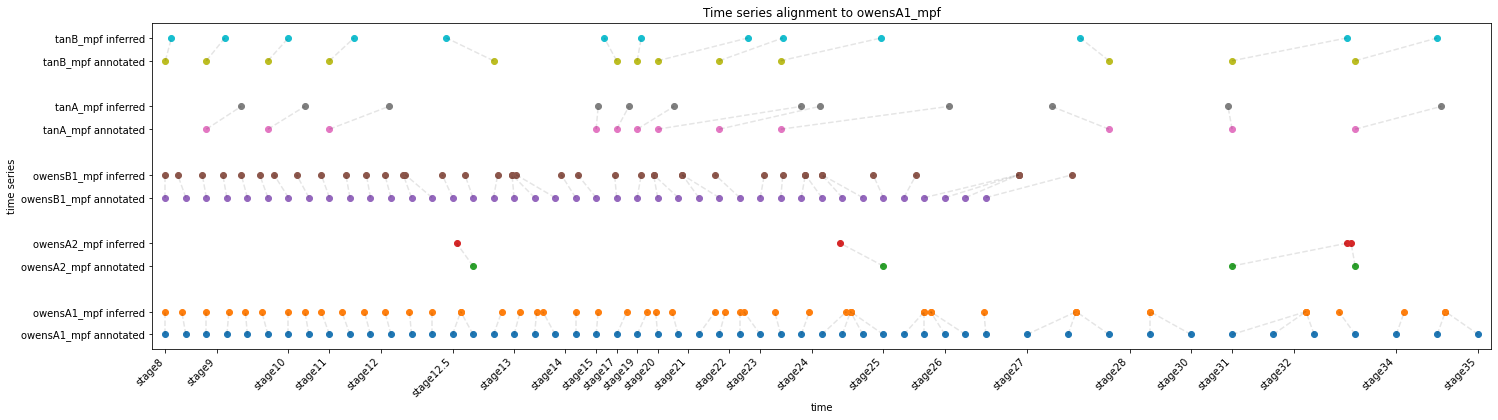

In [72]:
# xenopus developmental stages per extended_timepoints for template owensA1_mpf
all_mpf = [
    240.0,
    315.0,
    420.0,
    480.0,
    555.0,
    660.0,
    750.0,
    825.0,
    870.0,
    900.0,
    930.0,
    960.0,
    1005.0,
    1065.0,
    1110.0,
    1185.0,
    1290.0,
    1380.0,
    1500.0,
    1650.0,
    1740.0,
    1800.0,
    1890.0,
    2040.0,
    2160.0,
]
all_stages = [
    'stage8',
    'stage9',
    'stage10',
    'stage11',
    'stage12',
    'stage12.5',
    'stage13',
    'stage14',
    'stage15',
    'stage17',
    'stage19',
    'stage20',
    'stage21',
    'stage22',
    'stage23',
    'stage24',
    'stage25',
    'stage26',
    'stage27',
    'stage28',
    'stage30',
    'stage31',
    'stage32',
    'stage34',
    'stage35',
]
time2stage = dict(zip(all_mpf, all_stages))

# wide image
plt.rcParams['figure.figsize'] = [24, 6]

# create a dataframe with extended_timepoints as index, 
# and a numeric columns "x" to serve as axis.
# columns xticks and xlabels can be used to populate the plot axis.
all_mpf_int = [int(i) for i in all_mpf]
template_time = list2floats(template_time2samples)
x = []
xticks = []
xlabels = []
for t in range(0, int(template_time[-1]+1)):
    x.append(t)
    if t in all_mpf_int:
        xticks.append(t)
        xlabels.append(time2stage[t])
    else:
        xticks.append(np.NaN)
        xlabels.append(np.NaN)      
template = pd.DataFrame({
    "template_time": x,
    "x": x,
    "xticks": xticks,
    "xlabels": xlabels,
}).set_index("template_time")

plot_timeline(template, alignment_files)
